In [1]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import rospy
import rosbag

from visualization_msgs.msg import Marker, MarkerArray
from geometry_msgs.msg import Twist, PoseStamped, Pose, Point
from std_msgs.msg import Bool
import tf
from geometry_msgs.msg import Quaternion

import sys
# sys.path.insert(0, "src")


from utils.environment import *
import scipy.io as sio

import os



In [2]:

def make_directory(dir):
    try:
        os.mkdir(dir)
    except:
        print("%s folder already exists"%dir)


In [12]:
def parse_bag_and_save_trajectory_image_car(bagname, DT=0.5, A_MAX=2.0, V_MAX=5.0, DELTA_MAX=0.344):
    center_i = float(bagname.split("cnn_")[1][0])
    trial_i = int(bagname.split("cnn_")[1][2:-4])
    save_figname = "figs/expert_trajectories/" + str(int(center_i)) + "_" + str(int(trial_i)) 

    cover_x = center_i
    final_x = 5.0
    obs_x = (cover_x + final_x) / 2
    params = { "covers": [Circle([cover_x, 3.5], 2.0)],
       "obstacles": [Circle([obs_x, 9.], 1.5)],
       "initial": Box([2, -4.],[8, -2]),
       "final": Circle([final_x, 13], 1.0)
    } 

    bag = rosbag.Bag(bagname)

    states = []
    for topic, msg, t in bag.read_messages(topics=['/robot/state']):
        x, y = msg.pose.position.x, msg.pose.position.y
        quat = msg.pose.orientation
        th = tf.transformations.euler_from_quaternion([quat.x, quat.y, quat.z, quat.w])[2]
        V = msg.twist.linear.x
        beta = msg.twist.linear.y
        time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
        states.append([time, x, y, th, V, beta])
    states = np.array(states)


    controls = []
    for topic, msg, t in bag.read_messages(topics=['/robot/control']):
        b, a, d = msg.data.data
        brake = -(1 - b) * 0.5 * A_MAX
        accel = (1 - a) * 0.5 * A_MAX
        delta = d * DELTA_MAX
        time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
        controls.append([time, brake+accel, delta])
    controls = np.array(controls)

    dt = 0.1
    # training data
    # start_time = controls[np.where(controls[:,1] != 0)[0][0], 0]
    start_idx = np.where(states[:,2] > (states[0,2] + 0.2))[0][0]
    start_time = states[start_idx+1, 0]
    controls[:,0] -= start_time
    states[:,0] -= start_time
    times = np.arange(0, controls[-1,0], dt)
    controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
    states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
#     fig, ax = plt.subplots(figsize=(6,6))
#     _, ax = env.draw2D(ax=ax, kwargs=draw_params)

#     ax.scatter(states_even[:,0], states_even[:,1], zorder=5, alpha=0.1)
#     ax.axis("equal")
#     fig.savefig(save_figname)

    dt = DT
    times = np.arange(0, controls[-1,0], dt)
    controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
    states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
    train_data = np.concatenate([np.expand_dims(times, 1), states_even, controls_even], axis=1)
    # plt.scatter(states_even[:,0], states_even[:,1])

    times = np.arange(0, controls[-1,0], dt) + dt/2
    controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
    states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
    eval_data = np.concatenate([np.expand_dims(times, 1), states_even, controls_even], axis=1)

    return train_data, eval_data


In [39]:
bagname = "../expert_demo_ros/bags/coverage_cnn_1_3.bag"

center_i = float(bagname.split("cnn_")[1][0])
trial_i = int(bagname.split("cnn_")[1][2:-4])
save_figname = "figs/expert_trajectories/" + str(int(center_i)) + "_" + str(int(trial_i)) 

cover_x = center_i
final_x = 5.0
obs_x = (cover_x + final_x) / 2
params = { "covers": [Circle([cover_x, 3.5], 2.0)],
   "obstacles": [Circle([obs_x, 9.], 1.5)],
   "initial": Box([2, -4.],[8, -2]),
   "final": Circle([final_x, 13], 1.0)
}  

draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }
env = Environment(params)


In [40]:
train_data, eval_data = parse_bag_and_save_trajectory_image_car(bagname)

(-1.45, 8.45, -4.899996162878205, 14.899919420442306)

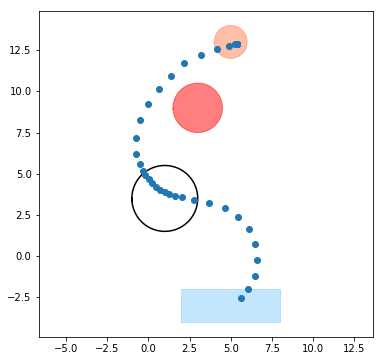

In [41]:
fig, ax = plt.subplots(figsize=(6,6))
_, ax = env.draw2D(ax=ax, kwargs=draw_params)

ax.scatter(eval_data[:,1], eval_data[:,2], zorder=5)
ax.axis("equal")

In [44]:
trainname = "expert/coverage_cnn/train_" +  str(int(center_i)) + "_" + str(int(trial_i)) 
evalname = "expert/coverage_cnn/eval_" +  str(int(center_i)) + "_" + str(int(trial_i)) 
np.save(trainname, train_data)
np.save(evalname, eval_data)

(-1.45, 8.45, -4.899996162878205, 14.899919420442306)

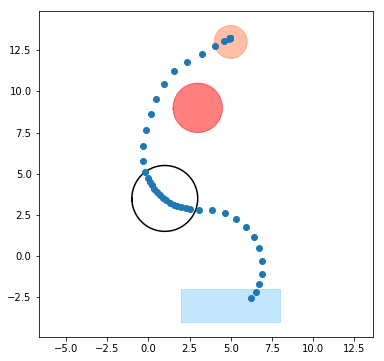

## saving environment images

In [33]:
for center_i in np.arange(1.0, 11):    
    cover_x = center_i
    final_x = 5.0
    obs_x = (cover_x + final_x) / 2
    params = { "covers": [Circle([cover_x, 3.5], 2.0)],
       "obstacles": [Circle([obs_x, 9.], 1.5)],
       "initial": Box([2, -4.],[8, -2]),
       "final": Circle([final_x, 13], 1.0)
    }  
    savepath = "figs/environments/" + str(center_i)
    make_directory(savepath)
    get_env_image(params, savepath)

figs/environments/1.0 folder already exists
figs/environments/2.0 folder already exists
figs/environments/3.0 folder already exists
figs/environments/4.0 folder already exists
figs/environments/5.0 folder already exists
figs/environments/6.0 folder already exists
figs/environments/7.0 folder already exists
figs/environments/8.0 folder already exists
figs/environments/9.0 folder already exists
figs/environments/10.0 folder already exists


In [15]:
# bag = rosbag.Bag("../expert_demo_ros/bags/coverage_test.bag")
# bag = rosbag.Bag("../expert_demo_ros/bags/coverage_test_2020-11-18-13-20-12.bag")
# bag = rosbag.Bag("../expert_demo_ros/bags/coverage_cnn_1_1.bag")
bag = rosbag.Bag(bagname)
A_MAX = rospy.get_param("A_MAX", 3)
V_MAX = rospy.get_param("V_MAX", 5.0)
DELTA_MAX = rospy.get_param("DELTA_MAX", 0.344)


In [5]:
states = []
for topic, msg, t in bag.read_messages(topics=['/robot/state']):
    x, y = msg.pose.position.x, msg.pose.position.y
    quat = msg.pose.orientation
    th = tf.transformations.euler_from_quaternion([quat.x, quat.y, quat.z, quat.w])[2]
    V = msg.twist.linear.x
    beta = msg.twist.linear.y
    time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
    states.append([time, x, y, th, V, beta])
states = np.array(states)



controls = []
for topic, msg, t in bag.read_messages(topics=['/robot/control']):
    b, a, d = msg.data.data
    brake = -(1 - b) * 0.5 * A_MAX
    accel = (1 - a) * 0.5 * A_MAX
    delta = d * DELTA_MAX
    time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
    controls.append([time, brake+accel, delta])
controls = np.array(controls)

In [13]:
for center_i in np.arange(1.0, 11):    
    cover_x = center_i
    final_x = 5.0
    obs_x = (cover_x + final_x) / 2
    params = { "covers": [Circle([cover_x, 3.5], 2.0)],
       "obstacles": [Circle([obs_x, 9.], 1.5)],
       "initial": Box([2, -4.],[8, -2]),
       "final": Circle([final_x, 13], 1.0)
    }  
    savepath = "figs/environments/" + str(center_i)
    make_directory(savepath)
    get_env_image(params, savepath)

figs/environments/1.0 folder already exists


## interpolating

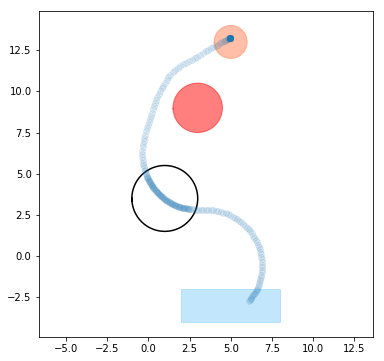

In [34]:
dt = 0.1
# training data
# start_time = controls[np.where(controls[:,1] != 0)[0][0], 0]
start_idx = np.where(states[:,2] > (states[0,2] + 0.2))[0][0]
start_time = states[start_idx+1, 0]
controls[:,0] -= start_time
states[:,0] -= start_time
times = np.arange(0, controls[-1,0], dt)
controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
fig, ax = plt.subplots(figsize=(6,6))
_, ax = env.draw2D(ax=ax, kwargs=draw_params)

ax.scatter(states_even[:,0], states_even[:,1], zorder=5, alpha=0.1)
ax.axis("equal")

fig.savefig(save_figname)
# sio.savemat('../hji/data/coverage_test/expert_traj.mat', {'expert_traj': states_even, 'time': times})

### for neural network training

In [60]:
dt = 0.5

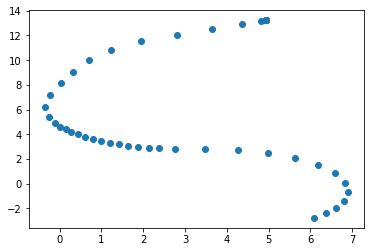

In [61]:
# training data
# start_time = controls[np.where(controls[:,1] != 0)[0][0], 0]
# start_time = states[np.where(np.abs(np.diff(states[:,2])) > 0.1)[0][0]+1, 0]

# controls[:,0] -= start_time
# states[:,0] -= start_time
times = np.arange(0, controls[-1,0], dt)
controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
plt.scatter(states_even[:,0], states_even[:,1])

# np.save('../hji/data/coverage_test/expert_traj_train', np.concatenate([np.expand_dims(times, 1), states_even, controls_even], axis=1))


In [85]:
np.concatenate([np.expand_dims(times, 1), states_even, controls_even], axis=1).shape

(45, 7)

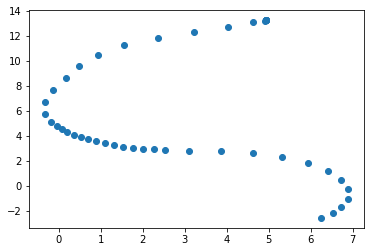

In [86]:
# eval data
# start_time = controls[np.where(controls[:,1] != 0)[0][0], 0]
# start_time = states[np.where(np.abs(np.diff(states[:,2])) > 0.1)[0][0]+1, 0]
# controls[:,0] -= start_time
# states[:,0] -= start_time
times = np.arange(0, controls[-1,0], dt) + dt/2
controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T
plt.scatter(states_even[:,0], states_even[:,1])

# np.save('../hji/data/coverage_test/test', np.concatenate([np.expand_dims(times, 1), states_even, controls_even], axis=1))


In [35]:
# x_train_, u_train_, stats = prepare_data("../../hji/data/" + args.type + "/expert_traj_train.npy")
# x_eval_, u_eval_, _ = prepare_data("../../hji/data/" + args.type + "/expert_traj_eval.npy")
d = np.load("../hji/stlhj/coverage_KinematicCar/traj.npy")
d = np.load("../hji/data/coverage_test/expert_traj_eval.npy")


In [36]:
d[:,0]

array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
        4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75,
       18.25, 18.75, 19.25])

In [37]:
x = d[:,1:5]
u = d[:,5:]

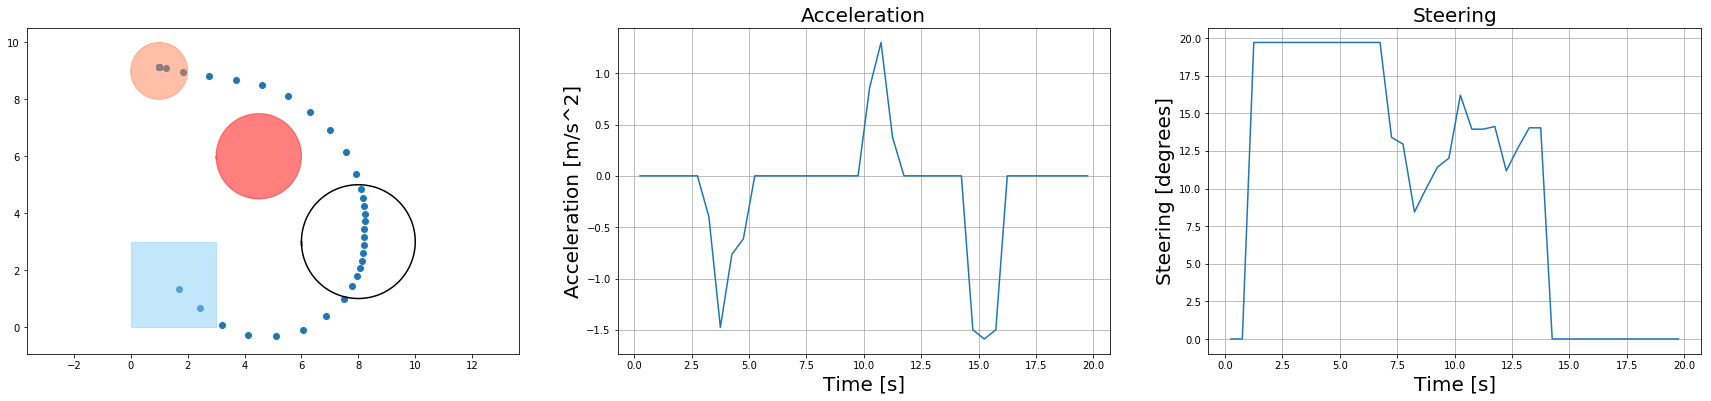

In [79]:
N = 100
params = { "covers": [Circle([8., 3.0], 2.0)],
       "obstacles": [Circle([4.5, 6.], 1.5)],
       "initial": Box([0., 0.],[3., 3.]),
       "final": Circle([1., 9.], 1.0)
        }   

# params = {  "covers": [],
#             "obstacles": [],
#             "initial": Box([-1., -1.],[1., 1.]),
#             "final": Box([4.0, 4.0],[6.0, 6.0])
#        }    
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }
env = Environment(params)

fig, ax = plt.subplots(1,3,figsize=(30,6))
ax1 = ax[0]
_, ax1 = env.draw2D(ax=ax1, kwargs=draw_params)
ax1.axis("equal")


alpha = states_even[:,3]/V_MAX
color_list = np.ones([alpha.shape[0], 3])
color_list[:,0] = alpha
# color_list[:,1] =  1 - alpha
ax[0].scatter(states_even[:,0], states_even[:,1])
plt.grid()

ax[1].plot(times, controls_even[:,0])
ax[1].set_title("Acceleration", fontsize=20)
ax[1].set_xlabel("Time [s]", fontsize=20)
ax[1].set_ylabel("Acceleration [m/s^2]", fontsize=20)
ax[1].grid()

ax[2].plot(times, controls_even[:,1]*180/np.pi)
ax[2].set_title("Steering", fontsize=20)
ax[2].set_xlabel("Time [s]", fontsize=20)
ax[2].set_ylabel("Steering [degrees]", fontsize=20)
ax[2].grid(True)